In [18]:
import formulas
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import ufloat, unumpy
import pandas as pd
from scipy.signal import find_peaks

In [19]:
def lineplot(x,y,label = None,xlabel = None, ylabel = None ,color = None, title = "Lineplot", **kwargs):
    '''
    Line plot, must call plt.show() after calling this function
    '''
    sns.lineplot(x=x, y=y, label=label,color = color, **kwargs)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.title(title)


def find_peak(y, y_tol = 0.5):
    '''
    ASSUMES that x data corresponding to y values is in increasing order.
    '''

    y = list(y)
    maxima_indices = find_peaks(y)[0] # gets indices of maxima in y

    if len(y) > 0:
        max_y = max(y)


        check_gt_half = lambda i: y[i] > y_tol*max_y # lambda function to check if y value is greater than y_tol * max_y

        maxima_indices = list(filter(check_gt_half, maxima_indices)) # filters out maxima that are not greater than half of max y

    return maxima_indices



def generate_combined_fft_plots(xlsx_path, sheet1_name, sheet2_name, 
                                label1 = None, label2 = None, 
                                combine_vt = False, freq_range = None, 
                                time_range = None, label_peaks = True,
                                vt_title = "V(t)", fft_title = "V(f)", y_tol =0.5):
    '''
    Generates a combined plot of the fft with data from two speerate sheets in the same excel file
    args:
        xlsx_path: path to excel file
        sheet1_name: name of first sheet
        sheet2_name: name of second sheet
        label1: label for first sheet
        label2: label for second sheet
    '''

    if combine_vt:

        plot_vt(xlsx_path,sheet1_name, color = "blue", label = label1, time_range = time_range)
        plot_vt(xlsx_path,sheet2_name, color = "orange", label = label2, time_range = time_range)
        plt.title(vt_title)
        plt.show()

    plot_fft(xlsx_path,sheet1_name, label = label1, color = "blue" ,freq_range=freq_range, label_peaks = label_peaks, y_tol = y_tol)

    plot_fft(xlsx_path,sheet2_name, label = label2, color = "orange", freq_range=freq_range, label_peaks = label_peaks, y_tol = y_tol)
    plt.title(fft_title)



    plt.show()
    return


def plot_vt(xlsx_path,sheet_name,time_range = None, label = None, title = None,**kwargs ):
    # TODO: abstract with plot_fft
    data = pd.read_excel(xlsx_path, sheet_name=sheet_name)


    if time_range is not None:
        data = data[(data["x"]>=time_range[0]) & (data["x"]<=time_range[1])]

        
    x = data["x"]
    y= data["y"]

    lineplot(x,y,label = label,xlabel = "Time (s)", ylabel = "Voltage (V)")

    if title is not None:
        plt.title(title)

    return

def plot_fft(xlsx_path,sheet_name, freq_range = None, label_peaks = True, label = None, title = None, round_peaks = True, **kwargs):
    data = pd.read_excel(xlsx_path, sheet_name=sheet_name)
    x_var = "Frequency (hz)"
    y_var = "IMABS(FFT(y))"
    if freq_range is not None:
        data = data[(data[x_var]>=freq_range[0]) & (data[x_var]<=freq_range[1])]

    x = data[x_var]
    y= data[y_var]
    lineplot(x,y,xlabel = "Frequency (Hz)", ylabel = "Amplitude (V)", label = label)

    if label_peaks:
        peaks = find_peak(y, y_tol = kwargs.get("y_tol",0.5))
        y = pd.Series(y)
        x = pd.Series(x)
        plt.scatter(x.iloc[peaks],y.iloc[peaks], marker = "o")

        for i, peak in enumerate(peaks):


            x_peak_rounded = round(x.iloc[peak],2) if not round_peaks else round(x.iloc[peak])
            y_peak_rounded = round(y.iloc[peak],2) if not round_peaks else round(y.iloc[peak])
            plt.annotate(f"({x_peak_rounded},{y_peak_rounded})", 
                         (x.iloc[peak],y.iloc[peak]), 
                         xytext = (x.iloc[peak]+0.1,y.iloc[peak]+0.1), fontsize = 8)
            
    if title is not None:
        plt.title(title)


    return 


def generate_fft_plots(xlsx_path, sheet_name, fft_title = "V(f)", vt_title = "V(t)", freq_range = None,time_range = None,**kwargs):

    plot_vt(xlsx_path,sheet_name,title = vt_title, time_range = time_range)
    plt.show()

    plot_fft(xlsx_path,sheet_name, title = fft_title,freq_range = freq_range, y_tol = kwargs.get("y_tol",0.5), round_peaks = kwargs.get("round_peaks",False))
    plt.show()
    return




A. BASIC FFT

In [20]:
a_data =pd.read_excel('data/AFT/AFT_data.xlsx', sheet_name = 'A.3').dropna(how='all', axis =1)


a_data.head()


,n,x,y,Hamming (n),Windowed (x),FFT(y),IMABS(FFT(y)),Frequency (hz),IMABS(FFT(y)).1,freq(0.1s),intensity(0.1s)
0,0,0.000000,0.000000,0.080000,0.000000,0,0,0,0,80.0,0.0
1,1,0.000488,0.302006,0.080002,0.000039,0,0,1,0,90.0,0.0
2,2,0.000977,0.575808,0.080009,0.000078,0,0,2,0,100.0,1024.0
3,3,0.001465,0.795837,0.080019,0.000117,0,0,3,0,110.0,0.0
4,4,0.001953,0.941544,0.080035,0.000156,0,0,4,0,120.0,0.0


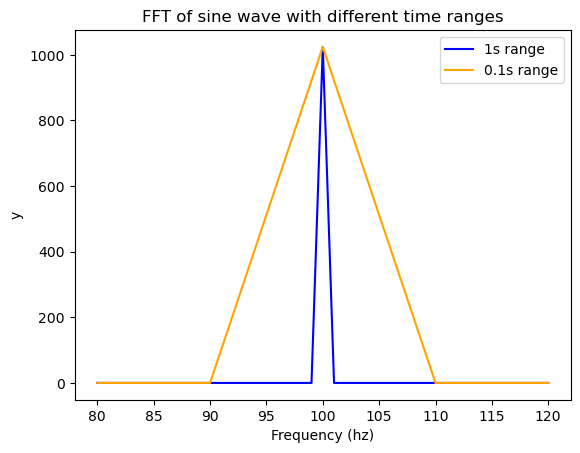

In [21]:
window_a= a_data[(a_data['Frequency (hz)'] >=80) & (a_data['Frequency (hz)'] <= 120)]

lineplot(x=window_a['Frequency (hz)'], y = window_a['IMABS(FFT(y))'], label ='1s range', color='blue')
lineplot(x=a_data['freq(0.1s)'], y = a_data['intensity(0.1s)'], label='0.1s range', color = 'orange',ylabel ='y',title= 'FFT of sine wave with different time ranges')
plt.show()

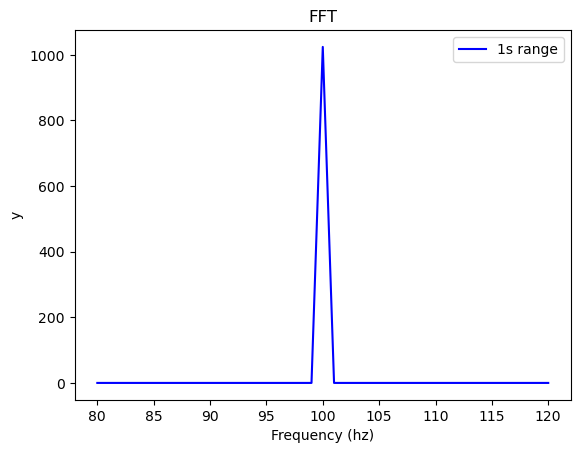

In [22]:
lineplot(x=window_a['Frequency (hz)'], y = window_a['IMABS(FFT(y))'], label ='1s range', color='blue',ylabel = "y", title= "FFT")
plt.show()

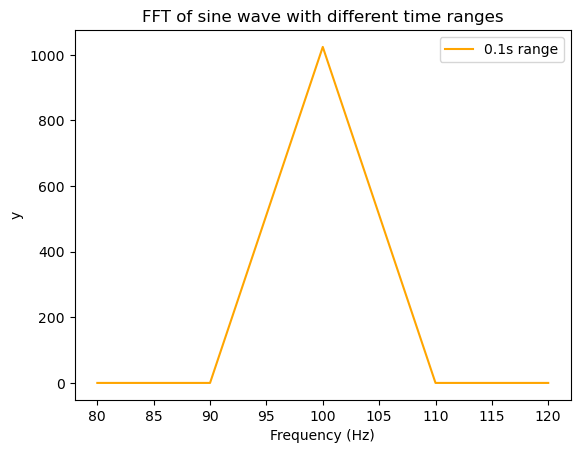

In [23]:
lineplot(x=a_data['freq(0.1s)'], y = a_data['intensity(0.1s)'], label='0.1s range', color = 'orange',ylabel ='y', xlabel ="Frequency (Hz)",title= 'FFT of sine wave with different time ranges')
plt.show()

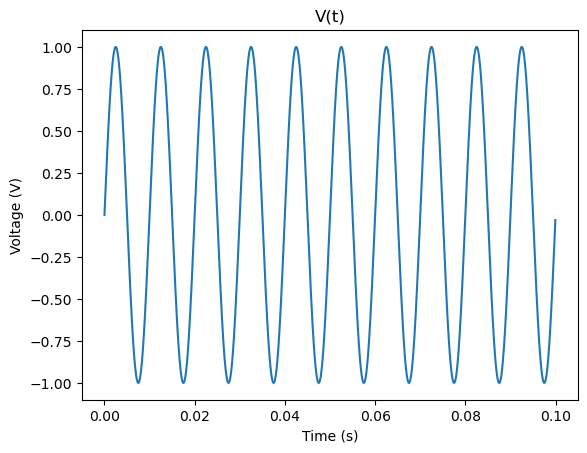

In [24]:
plot_vt(xlsx_path='data/AFT/AFT_data.xlsx', sheet_name='A', title = 'V(t)')

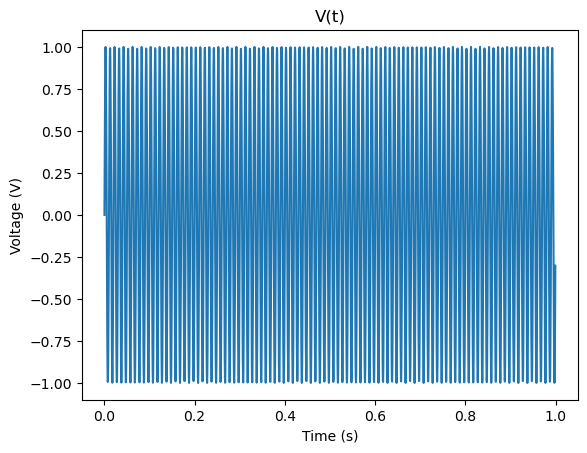

In [25]:
plot_vt(xlsx_path='data/AFT/AFT_data.xlsx', sheet_name='A.3', title = 'V(t)')

Part B - Sine and Square Waves:

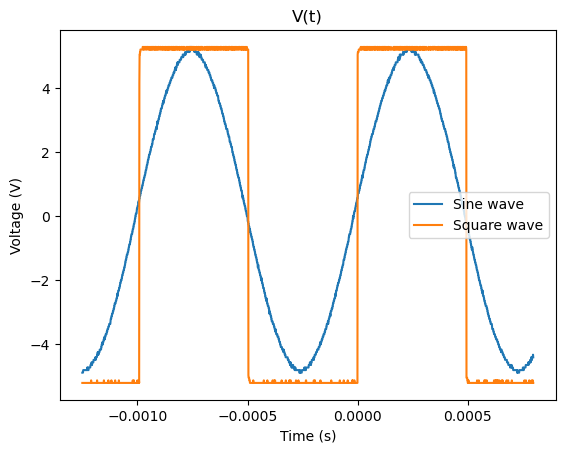

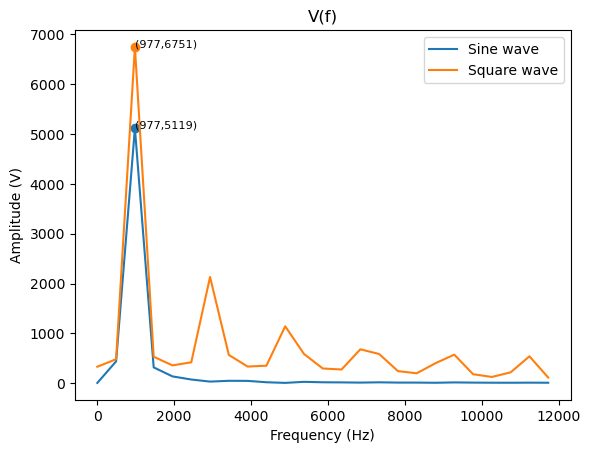

In [26]:
XLSX_PATH = 'data/AFT/AFT_data.xlsx'


generate_combined_fft_plots(xlsx_path = XLSX_PATH, 
                            sheet1_name = 'B_FFT_sine', 
                            sheet2_name = 'B_FFT_square', 
                            label1 = 'Sine wave',
                            label2 = "Square wave",
                            combine_vt = True,
                            freq_range = (0, 12000),
                            )


PART C - Beats


In [27]:
n_beats = 4
start_first = ufloat(0.467, 0.001)
end_fourth = ufloat(2.338, 0.001)

freq = n_beats / (end_fourth - start_first)
freq

2.137894174238375+/-0.001615948121927493

Part D, E - Whistle and Vowels

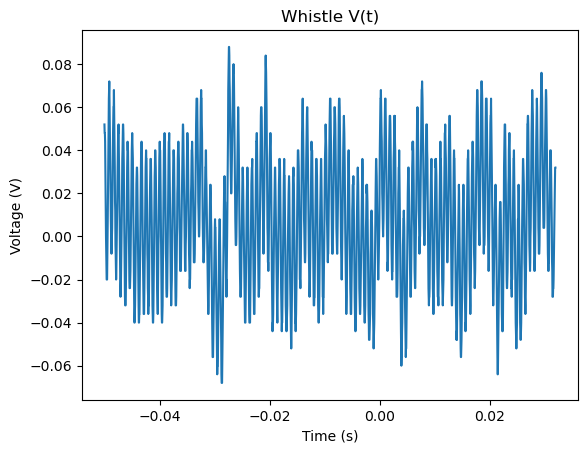

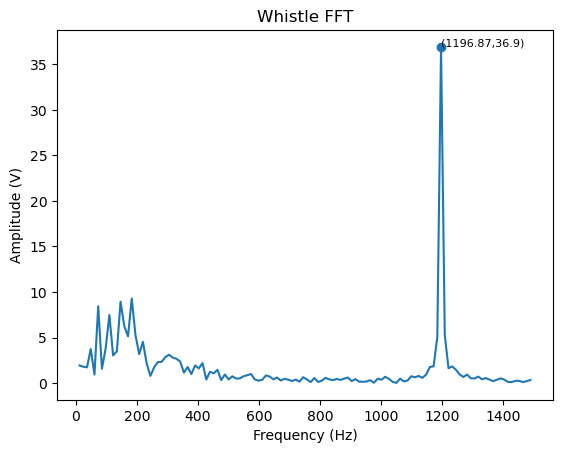

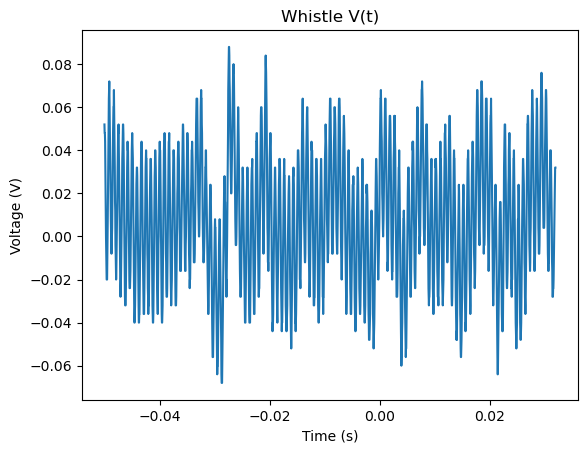

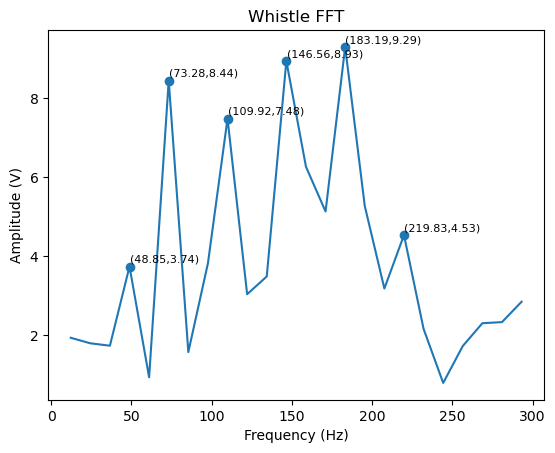

In [28]:
generate_fft_plots(

    xlsx_path=XLSX_PATH,
    sheet_name='D_retry',
    fft_title = 'Whistle FFT',
    vt_title = "Whistle V(t)",
    freq_range = (10, 1500),
    
)

plt.show()

generate_fft_plots(

    xlsx_path=XLSX_PATH,
    sheet_name='D_retry',
    fft_title = 'Whistle FFT',
    vt_title = "Whistle V(t)",
    freq_range = (10, 300),
    y_tol = 0.1
    
)

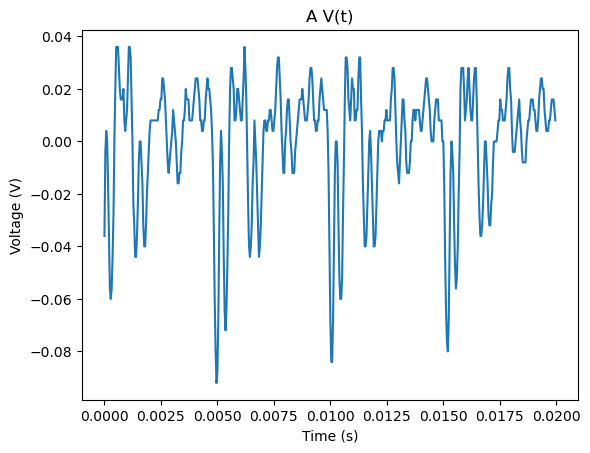

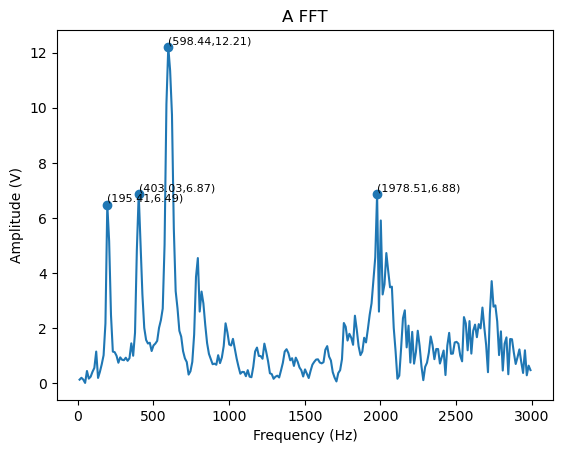

In [29]:
generate_fft_plots(

    xlsx_path=XLSX_PATH,
    sheet_name='E',
    fft_title = 'A FFT',
    vt_title = "A V(t)",
    freq_range = (10, 3000),
    time_range = (0,0.02),
    round_peaks = False,
)

plt.show()



Part F - Musical Harmonics

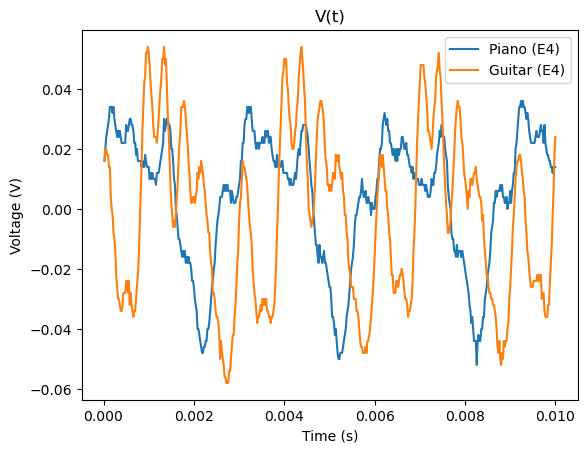

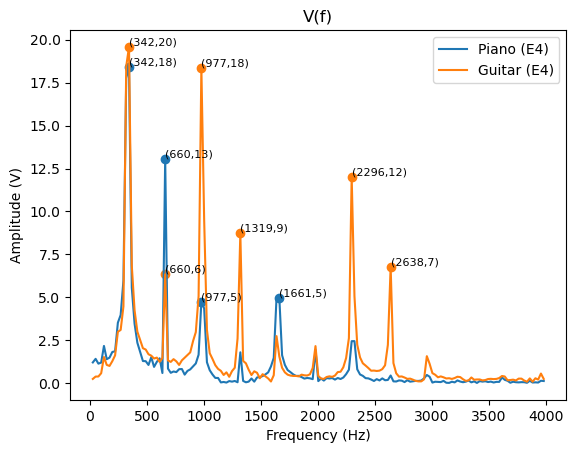

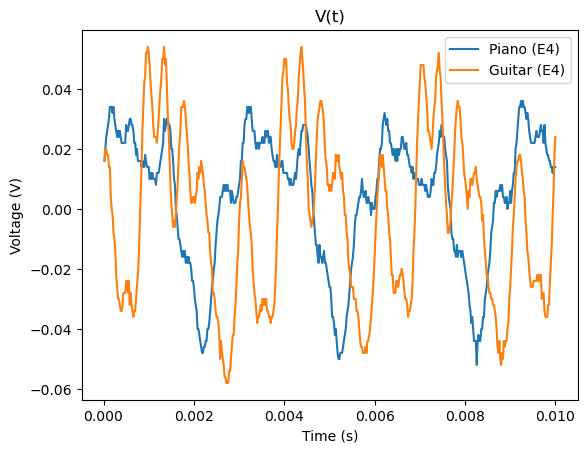

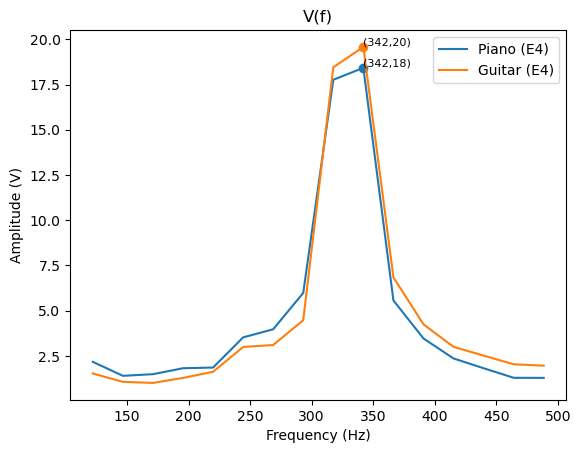

In [30]:

generate_combined_fft_plots(xlsx_path = XLSX_PATH, 
                            sheet1_name = 'F_piano', 
                            sheet2_name = 'F_guitar', 
                            label1 = 'Piano (E4)',
                            label2 = "Guitar (E4)",
                            combine_vt = True,
                            freq_range = (10, 4000),
                            time_range=(0, 0.01),
                            y_tol = 0.25
                            )


generate_combined_fft_plots(xlsx_path = XLSX_PATH, 
                            sheet1_name = 'F_piano', 
                            sheet2_name = 'F_guitar', 
                            label1 = 'Piano (E4)',
                            label2 = "Guitar (E4)",
                            combine_vt = True,
                            freq_range = (100, 500),
                            time_range=(0, 0.01),
                            y_tol = 0.25
                            )